In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yaml
import torch
import numpy as np
import normflows as nf
import matplotlib.pyplot as plt

from birds.models.june import June
from birds.calibrator import Calibrator

In [4]:
config = yaml.safe_load(open("./june_config.yaml"))
june = June(config, parameters_to_calibrate = ("beta_household", "beta_company", "beta_school"))

CPU times: user 4.68 s, sys: 5.84 s, total: 10.5 s
Wall time: 3.94 s


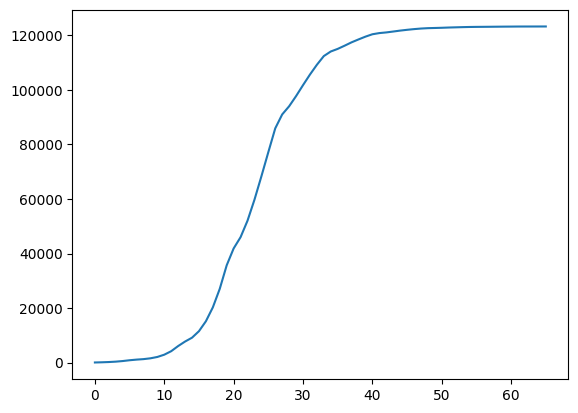

In [11]:
%%time
true_parameters = torch.tensor([0.9, 0.3, 0.6])
true_x = june.run(true_parameters)
true_data = june.observe(true_x)
plt.plot(true_data[0])

In [8]:
def make_flow():
    base = nf.distributions.base.DiagGaussian(len(true_parameters))
    num_layers = 5
    latent_size = len(true_parameters)
    flows = []
    for i in range(num_layers):
        param_map = nf.nets.MLP([2, 50, 50, 2], init_zeros=True)
        flows.append(nf.flows.AffineCouplingBlock(param_map))
        flows.append(nf.flows.Permute(latent_size, mode='swap'))
    flow = nf.NormalizingFlow(base, flows)
    return flow

In [10]:
torch.manual_seed(0)
prior = torch.distributions.MultivariateNormal(torch.tensor([0.5, 0.5, 0.5]), 1.0 * torch.eye(len(true_parameters)))
estimator = make_flow()
optimizer = torch.optim.AdamW(estimator.parameters(), lr=1e-3)
calibrator = Calibrator(model = june, 
                        posterior_estimator = estimator, 
                        prior=prior, 
                        data=true_data, 
                        optimizer=optimizer, 
                        n_samples_per_epoch=5,
                        w=0.001,
                        forecast_loss = torch.nn.MSELoss(),
                        log_tensorboard=True,
                        gradient_estimation_method="pathwise",
                        gradient_horizon=0)

calibrator.run(n_epochs=10000, max_epochs_without_improvement=50);

  0%|                                                                                                                                                            | 0/10000 [00:00<?, ?it/s]

observed_output tensor([ 71.,  92., 114., 137., 162., 187., 195., 203., 214., 231., 244., 257.,
        275., 284., 290., 303., 309., 317., 323., 332., 336., 339., 343., 349.,
        351., 357., 361., 364., 367., 368., 372., 378., 383., 388., 393., 395.,
        397., 400., 405., 409., 414., 415., 418., 421., 426., 430., 436., 440.,
        441., 442., 444., 446., 446., 447., 449., 450., 450., 453., 453., 455.,
        456., 456., 457., 458., 459., 460.])
simulated_output GradTrackingTensor(lvl=1, value=
    tensor([8.2000e+01, 3.2800e+02, 8.8000e+02, 1.7620e+03, 3.1100e+03, 5.3490e+03,
            5.6390e+03, 5.8640e+03, 8.8570e+03, 1.5553e+04, 2.1608e+04, 2.6300e+04,
            3.2803e+04, 3.3844e+04, 3.4510e+04, 4.1689e+04, 5.0964e+04, 5.6271e+04,
            6.0302e+04, 6.4221e+04, 6.5016e+04, 6.5574e+04, 6.9340e+04, 7.3077e+04,
            7.5018e+04, 7.6435e+04, 7.7675e+04, 7.7937e+04, 7.8129e+04, 7.9343e+04,
            8.0620e+04, 8.1379e+04, 8.1865e+04, 8.2269e+04, 8.2356e+0

  0%|                                                                                                                                                            | 0/10000 [00:15<?, ?it/s]


KeyboardInterrupt: 